In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("AQI.ipynb")

## Analyzing and Predicting AQI Data through Modeling




In this final project, we will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. The main goal at the end for you will be to understand how AQI varies both geographically and over time, and use your analysis (as well as other data that you can find) to be predict AQI at a certain point in time for various locations in California.

Through this final project, you will demonstrate your experience with:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

This is **part 1** of the project, which includes the data cleaning, guided EDA and open-ended EDA components of the project. This will help you for part 2, where you will be completing the modeling component. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [3]:
epa_weburl = "https://web.archive.org/web/20211118232504/https://aqs.epa.gov/aqsweb/airdata/" #updated link
epa_filenames = pd.read_csv('data/epa_filenames.csv')
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_county_2020
1,daily_county_aqi,daily_aqi_by_county_2020
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


Below is code that we used to extract the code from the AQI website, which we encourage you to understand! This will pull directly from the website urls and put it into your `data/` folder. 

In [4]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name): 
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

Use the below cell to explore each of the datasets, which can be accessed using the keys in the `name` column of `epa_filenames` above. Currently, the cell is viewing the `annual_county_aqi` dataset, but feel free to change it to whichever dataset you want to explore. 

In [5]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- BEGIN QUESTION -->

<br/>

### Question 0: Understanding the Data

Notice that for the table `annual_county_aqi`, the 90th percentile AQI is reported as a column. Why would the 90th percentile AQI be useful as opposed to the maximum? What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

<!--
BEGIN QUESTION
name: q0
manual: True
points: 2
-->

The 90th% AQI value represents 90% of the AQI values in the year which were less than the 90th % value. It is more useful than the maximum because the maximum, which represents the highest daily AQI value in a year, can be an outlier when being used to make estimates. It would mean that the maximum value is an outlier.

<!-- END QUESTION -->

<br/>

### Question 1a: Creating Month and Day Columns

In the `daily_county_aqi` table in `epa_data`, add two new columns called `Day` and `Month` that denote the day and month, respectively, of the AQI reading. The day and month should both be reported as an **integer** as opposed to a string (`Jan`, `Feb`, etc.)

hint: `pd.to_datetime` may be useful.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [6]:
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.DatetimeIndex(daily_county['Date']).month
daily_county['Day'] = pd.DatetimeIndex(daily_county['Date']).day


daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


In [7]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

### Question 1b: California Data

Currently, `epa_data` contains data for **all** counties in the United States. For the guided part of this project, we are specifically going to be focusing on AQI data for counties in California only. Your task is to assign `epa_data_CA` a dictionary mapping table names to dataframes. This map should have the same contents as `epa_data` but only tables that contain **daily data** in the state of `California`.

<!--
BEGIN QUESTION
name: q1b
points: 3
-->

In [8]:
epa_data_CA = {}

epa_data_copy = epa_data.copy()

keys = epa_filenames[epa_filenames["name"].str.contains("daily")]["name"]
for k in keys:
    epa_data_copy[k] = epa_data.get(k)[epa_data.get(k)["State Name"].str.contains("California")]
    
epa_data_copy.pop('annual_county_aqi')
epa_data_copy.pop('aqs_sites')

epa_data_CA = epa_data_copy
epa_data_CA.get('daily_county_aqi').head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14003,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14004,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
14005,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
14006,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
14007,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5


In [9]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

### Question 1c: Merging Site Information

Now take a look at this [link](https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports) and look under "Site ID". For later analysis, we want to first get the latitude and longitudes of each of the measurements in the `daily_county_aqi` table by merging two or more tables in `epa_data_CA` (one of the tables is `daily_county_aqi`).

Our final merged table should be assigned to `epa_data_CA_merged` and the result should contain the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Latitude`, and `Longitude`

<!--
BEGIN QUESTION
name: q1c
points: 4
-->

In [10]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']

left_df = epa_data_CA.get('daily_county_aqi')

left_df["Site Num"] = pd.to_numeric(left_df["Defining Site"].str.split("-").str[2])

right_df = epa_data.get('aqs_sites')[epa_data.get('aqs_sites')["State Code"].str.contains("06")]

merged = left_df.merge(right_df, left_on = ["Site Num", "County Code"], right_on = ["Site Number", "County Code"], how = "inner")
merged.rename(columns = {"State Name_x": "State Name"}, inplace = True)

epa_data_CA_merged = merged[cols]
epa_data_CA_merged.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935
1,California,Alameda,1,25,40,Good,06-001-0009,37.743065,-122.169935
2,California,Alameda,7,3,48,Good,06-001-0009,37.743065,-122.169935
3,California,Alameda,7,4,115,Unhealthy for Sensitive Groups,06-001-0009,37.743065,-122.169935
4,California,Alameda,7,5,78,Moderate,06-001-0009,37.743065,-122.169935


In [11]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

### Question 2a - Cleaning Traffic Data 

Throughout this project, you will be using other datasets to assist with analysis and predictions. Traditionally, to join dataframes we need to join on a specific column with shared values. However, when it comes to locations, exact latitudes and longitudes are hard to come by since it is a continuous space. First, lets look at such a dataset that we may want to merge on with `epa_data_CA_merged`. 

In the below cell, we have loaded in the `traffic_data` dataset, which contains traffic data for various locations in California. Your task is to clean this table so that it includes only the following columns (you may have to rename some): `District`, `Route`, `County`, `Descriptn`, `AADT`, `Latitude`, `Longitude`, where `AADT` is found by taking the sum of the back and ahead `AADT`s (you may run into some issues with cleaning the data in order to add these columns - `.str` functions may help with this). The metric AADT, annual average daily traffic, is calculated as the sum of the traffic north of the route (ahead AADT) and south of the route (back AADT). You also need to make sure to clean and remove any illegal values from the dataframe (hint: check `Latitude` and `Longitude`).

*Hint:* `str` functions you will likely use: `.strip()`, `.replace()`.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [12]:
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")

back_data = traffic_data[['Back_AADT']]
back_data.replace(to_replace = ' ', value = 0, inplace = True)
front_data = traffic_data[['Ahead_AADT']]
front_data.replace(to_replace = ' ', value = 0, inplace = True)

traffic_data['Back_AADT'] = back_data
traffic_data['Ahead_AADT'] = front_data

AADT = traffic_data['Back_AADT'].astype(int) + traffic_data['Ahead_AADT'].astype(int)
traffic_data['AADT'] = AADT
back_data.replace(to_replace = ' ', value = 0, inplace = True)

repl = r"[0-9]"
Lon_S_or_W_not_cleaned = traffic_data['Lon_S_or_W']
Lon_S_or_W_cleaned = traffic_data[['Lon_S_or_W']][Lon_S_or_W_not_cleaned.str.contains(repl)]
traffic_data[['Lon_S_or_W']] = Lon_S_or_W_cleaned
Lat_S_or_W_not_cleaned = traffic_data['Lat_S_or_W']
Lat_S_or_W_cleaned = traffic_data[['Lat_S_or_W']][Lat_S_or_W_not_cleaned.str.contains(repl)]
traffic_data[['Lat_S_or_W']] = Lat_S_or_W_cleaned
Lon_N_or_E_not_cleaned = traffic_data['Lon_N_or_E']
Lon_N_or_E_cleaned = traffic_data[['Lon_N_or_E']][Lon_N_or_E_not_cleaned.str.contains(repl)]
traffic_data[['Lon_N_or_E']] = Lon_N_or_E_cleaned
Lat_N_or_E_not_cleaned = traffic_data['Lat_N_or_E']
Lat_N_or_E_cleaned = traffic_data[['Lat_N_or_E']][Lat_N_or_E_not_cleaned.str.contains(repl)]
traffic_data[['Lat_N_or_E']] = Lat_N_or_E_cleaned

traffic_data.rename(columns = {'Lon_S_or_W' : "Longitude"}, inplace = True)
traffic_data.rename(columns = {'Lat_S_or_W' : "Latitude"}, inplace = True)
traffic_data_cleaned = traffic_data[['District', 'Route', 'County', 'Descriptn', 'AADT', "Longitude", "Latitude"]]
traffic_data_cleaned.tail()

,District,Route,County,Descriptn,AADT,Longitude,Latitude
7115,12,605,ORA,"SEAL BEACH, JCT RTE 22",46100,-118.0914735,33.7786335
7116,12,605,ORA,JCT. RTE. 405,212200,-118.0917676,33.78441396
7117,12,605,ORA,"LOS ALAMITOS, KATELLA AVENUE",326800,-118.0820302,33.80279867
7118,12,605,ORA,ORANGE/LOS ANGELES COUNTY LINE,170000,-118.081547,33.80613969
7119,3,99,SAC,BREAK IN ROUTE,0,-121.4736488,38.55883754


In [13]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b - Merging on Traffic Data 

Traditionally, we could employ some sort of join where we join `epa_data_CA_merged` rows with the row in `traffic_data` that it is the "closest" to, as measured by euclidean distance. As you can imagine, this can be quite tedious so instead we will use a special type of join called a **spatial join**, which can be done using the package `geopandas`, which is imported as `gpd`. The documentation for `geopandas` is linked [here](https://geopandas.org/docs/reference/api/geopandas.sjoin_nearest.html). Please use this as a resource to do the following tasks: 

 - turn `traffic_data_cleaned` and `epa_data_CA_merged` into a geopandas dataframe using the latitude and longitude.
 - Use a spatial join (which function is this in the documentation?) to match the correct traffic row information to each entry in `epa_data_CA_merged`. 

Your final dataframe should be assigned to `gpd_epa_traffic` with the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Site Lat`, `Site Long`, `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [14]:
traffic_data_cleaned_gpd = gpd.GeoDataFrame(
    traffic_data_cleaned, geometry=gpd.points_from_xy(traffic_data_cleaned.Longitude, traffic_data_cleaned.Latitude))
epa_data_CA_merged_copy = epa_data_CA_merged.copy()
epa_data_CA_merged_gpd = gpd.GeoDataFrame(
    epa_data_CA_merged_copy, geometry=gpd.points_from_xy(epa_data_CA_merged_copy.Longitude, epa_data_CA_merged_copy.Latitude))

gpd_epa_traffic = gpd.GeoDataFrame.sjoin_nearest(epa_data_CA_merged_gpd, traffic_data_cleaned_gpd)

gpd_epa_traffic.rename(columns = {'Longitude_right' : "Traffic Long"}, inplace = True)
gpd_epa_traffic.rename(columns = {'Latitude_right': 'Traffic Lat'}, inplace = True)
gpd_epa_traffic.rename(columns = {'Latitude_left' : 'Site Lat'}, inplace = True)
gpd_epa_traffic.rename(columns = {'Longitude_left' : 'Site Long'}, inplace = True)

gpd_epa_traffic = gpd_epa_traffic[['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 
                                   'Defining Site', 'Site Lat', 'Site Long', 'Traffic Lat', 'Traffic Long', 'Descriptn', 'AADT']]

gpd_epa_traffic['Traffic Long'] = gpd_epa_traffic['Traffic Long'].astype(float)
gpd_epa_traffic['Site Lat'] = gpd_epa_traffic['Site Lat'].astype(float)
gpd_epa_traffic['Site Long'] = gpd_epa_traffic['Site Long'].astype(float)
gpd_epa_traffic['Traffic Lat'] = gpd_epa_traffic['Traffic Lat'].astype(float)

gpd_epa_traffic.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Site Lat,Site Long,Traffic Lat,Traffic Long,Descriptn,AADT
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
1,California,Alameda,1,25,40,Good,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
2,California,Alameda,7,3,48,Good,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
3,California,Alameda,7,4,115,Unhealthy for Sensitive Groups,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
4,California,Alameda,7,5,78,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300


In [15]:
grader.check("q2b")

q2b results: All test cases passed!

<br/><br/>

---
## Section 2: Guided EDA


### Question 3a: Initial AQI Analysis

Assign a `pd.Series` object to `worst_median_aqis` that contains the states with the top 10 worst median AQIs throughout the year 2020, as measured by the average median AQIs across all counties for a single state. Your result should have index `state`, the column value should be labelled `Average Median AQI`, and it should be arranged in descending order.

Now, assign the same thing to `worst_max_aqis`, except instead of aggregating the average median AQIs across all counties, aggregate the average **max AQIs** across all counties. Your result should have the same shape and labels as before, except the column value should be labelled `Average Max AQI`. 

Note: you may have to remove a few regions in your tables. Make sure every entry in your output is a **US State**.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [16]:
worst_median_aqis = epa_data.get('annual_county_aqi').groupby("State")["Median AQI"].mean().sort_values(ascending = False).to_frame()
worst_median_aqis.drop(["Country Of Mexico", "District Of Columbia", "Virgin Islands", "Puerto Rico"], inplace = True)
worst_median_aqis = worst_median_aqis.squeeze()[:10]

worst_max_aqis = epa_data.get('annual_county_aqi').groupby("State")["Max AQI"].mean().sort_values(ascending = False).to_frame()
worst_max_aqis.drop(["Country Of Mexico", "District Of Columbia", "Virgin Islands", "Puerto Rico"], inplace = True)
worst_max_aqis = worst_max_aqis.squeeze()[:10]

print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
print("Worst Max AQI : \n{}".format(worst_max_aqis))

np.round(list(worst_max_aqis), 2)
worst_median_aqis

Worst Median AQI : 
State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Median AQI, dtype: float64

Worst Max AQI : 
State
Oregon          430.347826
Washington      334.419355
California      286.981132
Arizona         238.230769
Idaho           197.857143
Wyoming         196.666667
Nevada          196.666667
Montana         137.421053
Rhode Island    133.000000
Connecticut     124.750000
Name: Max AQI, dtype: float64


State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Median AQI, dtype: float64

In [17]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 3b: Worst AQI States

What are the states that are in both of the top 10 lists? Why do you think most of these states are on both of the lists?

<!--
BEGIN QUESTION
name: q3b
manual: True
points: 2
-->

California, Arizona, Connecticut, and Nevada are the states that appear in both of the top 10 lists. Most of these states are on both of these lists as a result of high emissions by automobiles and factories, as well as emissions from forest fires.

<!-- END QUESTION -->

<br/>

### Question 4a: Missing AQI Data

We want to see the accessibility of the AQI data across states. In the following cell, assign `days_with_AQI` to a series that contains the state as the index and the average number of days with AQI entries across all counties in that state as the value. Make sure to label the series as `Days with AQI` and sort in ascending order (smallest average number of days at the top). As before, make sure to remove the regions that are not **US States** from your series.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [18]:
days_with_AQI = epa_data.get('annual_county_aqi').groupby("State")["Days with AQI"].mean().sort_values(ascending = True)
days_with_AQI.drop(["Country Of Mexico", "District Of Columbia", "Virgin Islands", "Puerto Rico"], inplace = True)

days_with_AQI.head()

State
Alaska        235.222222
Arkansas      251.545455
New Mexico    264.062500
Virginia      265.303030
Colorado      278.892857
Name: Days with AQI, dtype: float64

In [19]:
grader.check("q4a")

q4a results: All test cases passed!

<br/>

### Question 4b: What are the missing dates?

In the following cell, we create the series `ca_aqi_days` that outputs a series with each county in California mapped to the number of days that they have AQI data on. Notice that there exists a few counties without the full year of data, which is what you will be taking a closer look at in the following two parts.

In [20]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(10)

54    274
96    331
63    351
98    353
49    359
76    360
51    364
57    364
72    365
79    366
Name: Days with AQI, dtype: int64

#### Question 4bi: Missing Days

Assign `county_to_missing_dates` to a dictionary that maps each county with less than the full year of data to the dates that have missing AQI data. Make sure that your keys are just the county name (no whitespace around it or `, California` appended to it) and the values are of the format `yyyy-mm-dd`.

<!--
BEGIN QUESTION
name: q4i
points: 2
-->

In [21]:
daily_county = epa_data.get('daily_county_aqi')
daily_county_ca = daily_county[daily_county['State Name']=='California']

county_to_missing_dates = {}
missing_df = ca_annual_data[ca_annual_data['Days with AQI'] <= 365]
missing_counties = list(missing_df['County'].unique())


for county in missing_counties:
    missing_dates = daily_county_ca[daily_county_ca['county Name']=='Yolo']['Date'].isin(daily_county_ca[daily_county_ca['county Name']==county]['Date'])
    county_to_missing_dates[county] = daily_county_ca[daily_county_ca['county Name']=='Yolo']['Date'][~missing_dates].values.tolist()

In [22]:
grader.check("q4i")

q4i results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4bii: Missing Days

Are there any key missing dates in common between the counties that have missing AQI data? What two counties have the most missing days and why do you think they do?

<!--
BEGIN QUESTION
name: q4bii
manual: True
points: 2
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



<br/>

### Question 5a: AQI over Time 

Assign `aqi_per_month` to a series of the average aqi per month across all US states and `aqi_per_month_CA` to a series of the average AQI per month across California.

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [23]:
aqi_per_month = daily_county.groupby('Month').agg('mean')['AQI']
aqi_per_month_CA = daily_county[daily_county['State Name']=='California'].groupby('Month').agg('mean')['AQI']


print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


In [24]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 5b: AQI over Time Analysis 

Is there anything interesting that you notice in `aqi_per_month_CA`? If so, why do you think that is?

<!--
BEGIN QUESTION
name: q5b
manual: True
points: 1
-->

While the average AQI remains relatively constant throughout most of the year, it dramatically spikes during the months of August, September, and October. This is likely because wildfire season typically peaks during these months, causing a significantly higher average AQI.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 5c: Modeling AQI over Time

Based on the AQI pattern in the year 2020, if we were to model AQI over the last 10 years, with the average AQI per year being the same, what sort of parametric function $f(x)$ would you use? Let us say that we see a linear increase in the average AQI per year over the last 10 years instead, then what parametric function $g(x)$ would you use?

<!--
BEGIN QUESTION
name: q5c
manual: True
points: 3
-->

Since there is an increase followed by a decrease in AQI, it can be modeled using a sinusoidal curve. For a linear increase, we add the sine curve to a linear function representing the linear increase, which will result in an increase for all AQI values.

<!-- END QUESTION -->



<br/>

### Question 6a: Create Heatmap Buckets

Now we want to create a function called `bucket_data`, which takes in the following parameters: `table`, `resolution`. It outputs a pivot table with the latitude bucket (smallest latitude for that grid point) on the index and the longitude bucket (smallest longitude for that grid point) on the columns. The values in the pivot table should be the average AQI of the monitor sites inside that respective rectangle grid of latitudes and longitudes. The following should be the output of `bucket_data(epa_data_CA_merged, np.mean, 5)`:

<img src="images/q6a.png" width="600px" align="center"/>

The `resolution` parameter describes the number of buckets that the latitudes and longitudes are divided into on the heatmap. As an example, let us say that the range of longitudes for site monitors are between \[100, 110\]; make sure that the start of the range is exactly the **minimum** of all longitude values of your site monitors and the end of the range is the exactly the **maximum** of all longitude values of your site monitors. Let us say that we have a resolution of 10. Then we have the buckets 
$$([100, 101], [101, 102], ..., [109, 110])$$

The column and row labels of this dataframe should be labelled as the **start** of the bucket. In the case of the example above, the names of the buckets should be $ 100, 101, \dots 109 $. Note that we are just looking at the longitude dimension in this example, and you have to do do the same for the latitude dimension along the rows in order to build the pivot table.

Finally, make sure the row and column labels of your pivot table are **exactly** the same as the example given above. 
<!--
BEGIN QUESTION
name: q6a
points: 6
-->

In [25]:
#solution given by staff
def bucket_data(table, aggfunc, resolution):
    table = table.copy()
    
    long_buckets = np.sort(np.linspace(table['Longitude'].min(), table['Longitude'].max(), num=resolution, endpoint=False))
    lat_buckets = np.sort(np.linspace(table['Latitude'].min(), table['Latitude'].max(), num=resolution, endpoint=False))    
    
    long_buckets_map = dict(list(zip(long_buckets, np.around(long_buckets, decimals=2))))
    lat_buckets_map = dict(list(zip(lat_buckets, np.around(lat_buckets, decimals=2))))
    
    get_lat_bucket_num = lambda loc: lat_buckets_map.get(lat_buckets[lat_buckets <= loc].max())
    get_long_bucket_num = lambda loc: long_buckets_map.get(long_buckets[long_buckets <= loc].max())

    table['lat_bucket'] = table['Latitude'].apply(get_lat_bucket_num)
    table['long_bucket'] = table['Longitude'].apply(get_long_bucket_num)

    pivot_cols = ['lat_bucket', 'long_bucket', 'AQI']
    return pd.pivot_table(table[pivot_cols], index='lat_bucket', columns='long_bucket', aggfunc = aggfunc)

bucket_data(epa_data_CA_merged, np.mean, 5)

# UPDATED TEST, must pass only this test. They will update autograder after Tuesday midnight
np.round(bucket_data(epa_data_CA_merged, np.median, 5).iloc[:,0].loc[36.25], 2) == 36

True

In [26]:
grader.check("q6a")

q6a results: All test cases passed!

<br/>

### Question 6b: Visualize Heatmap

Assign `heatmap_data` to a heatmap bucket pivot table aggregated by median with resolution 30 for California AQI for the month of september. The code in the following cell will plot this heatmap for you. 

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

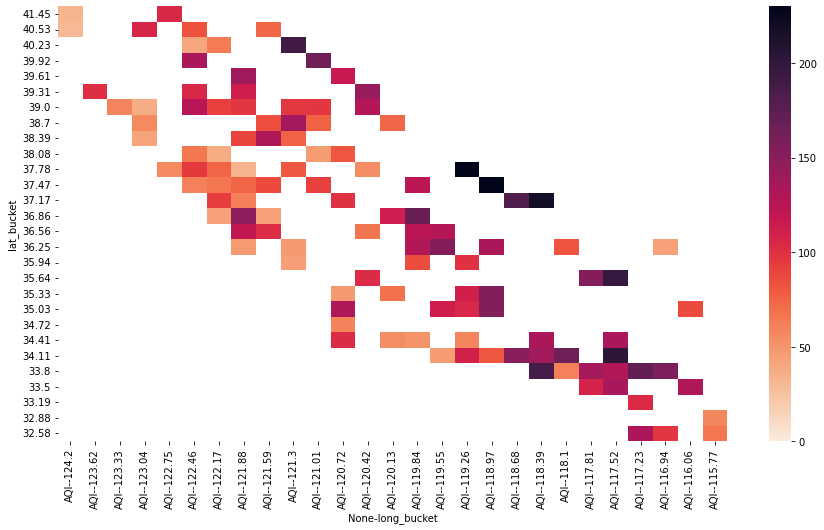

In [27]:
heatmap_data = bucket_data(epa_data_CA_merged[epa_data_CA_merged['Month'] == 9], 'median', 30)

#create visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [28]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 6c: Analyze Heatmap

Look up where the dark regions correspond to. Does this heatmap make sense?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

Yes, this heatmap makes sense. Some of the darkest regions correspond to places such as Death Valley National Park, Joshua Tree National Park, and Los Angeles. It makes sense that these regions are the darkest on the heatmap because they have a higher occurrence of forest fires.

<!-- END QUESTION -->



<br/><br/>

---
## Part 3: Open-Ended EDA

Not that we have explored the data both spatially and temporally, we want to be able to look at what other indicators there are for air quality in California. Through the previous few questions we have discussed that wilfire data as well as temperature may be good indicators, but we can explitly look at correlations via the temperature to verify our hypothesis. Like temperature, there are other columns of data such as particulate matter, chemical concentrations, wind data, etc. Your open-ended EDA will be useful for filling in missing points in the heatmap that you created in question 4b. 

Your goal in this question is to find relationships between AQI and other features in the current datasets, across time and space. Your exploration can include, but is not limited to: 
- Looking at correlations between AQI and various columns of interest in `epa_data_CA`.
    - This will require some merging, which you can look at question 1 for reference. 
- Performing clustering and/or other unsupervised learning methods such as PCA to discover clusters or useful (combinations of) features in the data.
- Merging and exploring other external datasets that you may think are useful.

<!-- BEGIN QUESTION -->

### Question 7a - Code and Analysis

Please complete all of your analysis in the **single cell** below based on the prompt above.

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 10
-->

In [29]:
# visualization #1
def bucket_data_temp(table, aggfunc, resolution):
    '''Create heatmap for SO2 Observation Percent'''
    long_buckets = np.sort(np.linspace(table['Longitude'].min(), table['Longitude'].max(), num=resolution, endpoint=False))
    lat_buckets = np.sort(np.linspace(table['Latitude'].min(), table['Latitude'].max(), num=resolution, endpoint=False))    
    
    long_buckets_map = dict(list(zip(long_buckets, np.around(long_buckets, decimals=2))))
    lat_buckets_map = dict(list(zip(lat_buckets, np.around(lat_buckets, decimals=2))))
    
    get_lat_bucket_num = lambda loc: lat_buckets_map.get(lat_buckets[lat_buckets <= loc].max())
    get_long_bucket_num = lambda loc: long_buckets_map.get(long_buckets[long_buckets <= loc].max())

    table['lat_bucket'] = table['Latitude'].apply(get_lat_bucket_num)
    table['long_bucket'] = table['Longitude'].apply(get_long_bucket_num)

    pivot_cols = ['lat_bucket', 'long_bucket', 'Arithmetic Mean']
    return pd.pivot_table(table[pivot_cols], index='lat_bucket', columns='long_bucket', aggfunc = aggfunc)

daily_temp = epa_data.get('daily_wind') #wind data is actually the temp data
heatmap_temp_data = bucket_data_temp(daily_temp[daily_temp['State Name'] == 'California'], 'mean', 90)


# visualization #2
daily_no2 = epa_data.get('daily_no2')[epa_data.get('daily_no2')["State Name"] == "California"]
daily_no2 = daily_no2[daily_no2['City Name'] == 'Los Angeles']
daily_so2 = epa_data.get('daily_so2')[epa_data.get('daily_so2')["State Name"] == "California"]
daily_so2 = daily_so2[daily_so2['City Name'] == 'Los Angeles']

chemicals = daily_no2.merge(daily_so2, on = ["Site Num", "County Code"], how = "inner")
chemicals.rename(columns = {"Observation Percent_x": "NO2 Observation Percent", "Observation Percent_y": "SO2 Observation Percent", "AQI_x": "AQI"}, inplace = True)
keep_cols = ['NO2 Observation Percent', 'SO2 Observation Percent', 'AQI']
chemicals = chemicals[keep_cols]

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7b - Visualization

Please create **two** visualizations to summarize your analysis above. The only restrictions are that these visualizations **cannot** simply be scatterplots between two features in the dataset(s) and **cannot** be of the same type (dont make two bar graphs, for example). 

<!--
BEGIN QUESTION
name: q7b
manual: True
points: 4
-->

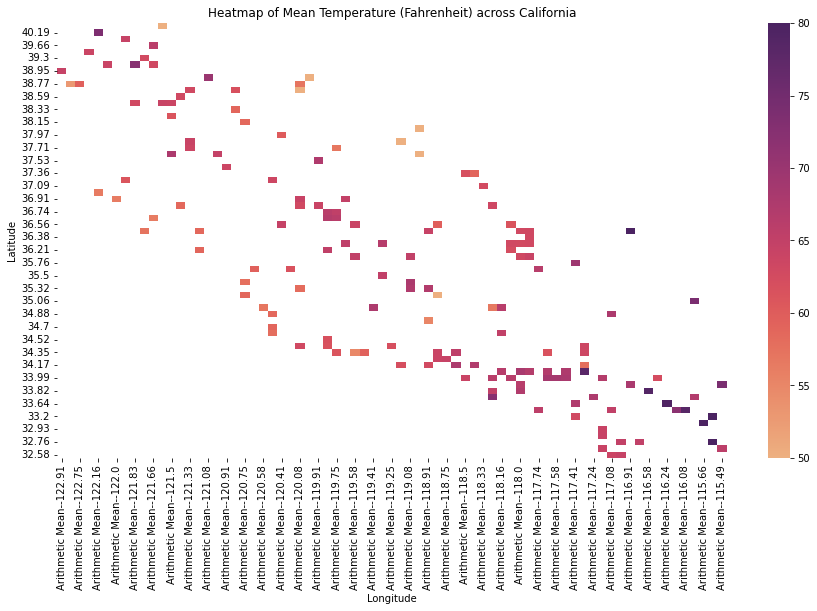

In [30]:
# visualization #1
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_temp_data, vmin=50, vmax=80, cmap = 'flare')
ax.invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Mean Temperature (Fahrenheit) across California')
plt.show()

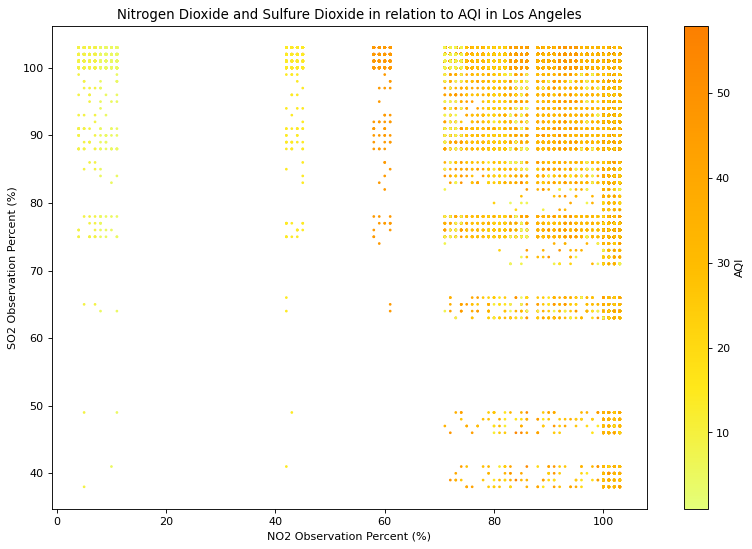

In [31]:
# visualization #2
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

jitter_x = np.random.randint(4, size=len(chemicals))
jitter_y = np.random.randint(4, size=len(chemicals))

plt.scatter(chemicals['NO2 Observation Percent']+jitter_x, chemicals['SO2 Observation Percent']+jitter_y, c = chemicals['AQI'], cmap='Wistia', s = 2);
plt.xlabel('NO2 Observation Percent (%)')
plt.ylabel('SO2 Observation Percent (%)')
color_bar = plt.colorbar();
color_bar.set_label('AQI');
plt.title('Nitrogen Dioxide and Sulfure Dioxide in relation to AQI in Los Angeles');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7c - Summary

In a paragraph, summarize the your findings and visualizations and explain how they will be useful for predicting AQI. Make sure that your answer is thoughtful and detailed in that it describes what you did and how you reached your conclusion. 

<!--
BEGIN QUESTION
name: q7c
manual: True
points: 4
-->

For our first visualization, we were interested in whether regions with high temperatures align with the same areas that have high AQI from Question 6b. We were interested in this connection because high atmospheric temperatures are generally the result of the burning of fossil fuels, which can worsen air quality—particularly in communities with high vehicular use. We decided to use a heatmap to analyze temperature so that we can geospatially compare regions with high temperature to those with high AQI. 


Upon comparing our heatmap with that of Question 6b, it appears that the same areas with high AQI also have high temperatures. This Exploratory Data Analysis will be helpful for predicting AQI because we can now consider observed percent temperature as an important data feature in the prediction of AQI. 


For our second visualization, we wanted to explore how gases commonly connected to wildfires relate to AQI in Los Angeles—a city whose air quality is typically affected by wildfire smoke. Two gases that are emitted during wildfires include Nitrogen Dioxide and Sulfur Dioxide (https://www.nationalgeographic.com/science/article/how-breathing-wildfire-smoke-affects-the-body).  To observe how each of these gases relate to AQI in LA, we plotted a scatterplot of each gas and AQI shown through color. To avoid overplotting, we jittered the data. 

From the scatterplot, we saw that the highest AQI values are observed when NO2 and SO2 are highest, and the lowest AQI values occur when observed NO2 and SO2 are the lowest. This Exploratory Data Analysis will be helpful for predicting AQI because we can consider observed NO2 and SO2 as important data features in the prediction of AQI, as seen in Los Angeles.

<!-- END QUESTION -->



<br/><br/>

---
## Part 4: Guided Modeling

For this part, we will be looking at some open-ended modeling approaches to answering the question of predicting AQI given a location and a date. 

### Question 8 - Interpolation

For this part, we will be using a simple interpolation to find the missing grid values for AQI on the heatmap visualization that you produced in part 1. Simple linear interpolation just takes the locations' values and averages them to produce an estimate of the current location. Though this is not as predictive (we are not predicting based on features about the location itself), it will give you a sense of the task at hand for the remainder of the project. 

As a reminder, the heatmap produced after running the cell below is the one you produced for question 6b when creating a visualization for the AQI in California for the month of september. It produces white spaces where there exist `NaN` values in the pivot table. 

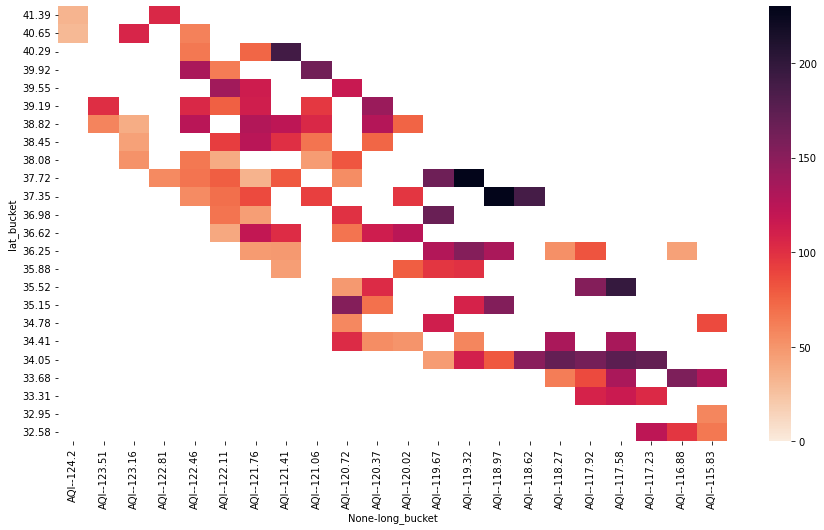

In [32]:
table_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(table_sep, np.median, 25)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

<br/>

### Question 8a - Simple Linear Interpolation
As previously mentioned, interpolation is a technique that is used to predict labels in a dataset by forming a model out of the data that is already labelled. In this case, we have a pivot table that we use to create a heatmap, but there contains many `NaN` values that we want to fill in. 

- Create the function `fill_bucket` that takes in the following parameters:
    - `pivot_table`: the pivot table that we are providing. 
    - `lat_bucket`: the bucket number that the latitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $, from lowest to highest value latitudes. 
    - `lon_bucket`: the bucket number that the longitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $. from lowest to highest value longitudes.
    
- In the pivot table, every value has cells above (A cells), cells below (B cells), cells to the left (L cells), and cells to the right (R cells). We will say that a direction (R for example) is valid if and only if there exists a cell **anywhere** to its right that is not `NaN`. The closest such cell will be called the "closest R cell". The same goes for the rest of the directions. For the cases below, assuming that our current cell is called cell K. 
    - If cell K is not `NaN`, then simply return the AQI at that given cell.
    - **Only** if there are **at least** three valid directional cells (ex. has A, B, and L valid but not R valid), we will call K *interpolable*. If K is *interpolable*, then interpolate K by assigning it an AQI value equal to the average of the closest cell AQIs in each of the valid directions. 
    - If K is *not interpolable*, then do not do anything and simply return `NaN`.
- The return value of `fill_bucket` should be the the value assigned to K. **DO NOT** mutate the cell K in the pivot table yet.

<!--
BEGIN QUESTION
name: q8a
points: 6
-->

In [33]:
def fill_bucket(pivot_table, lat_bucket, lon_bucket):
    # left
    left = False
    closest_left = np.nan
    if lon_bucket != 0:
        # left = pd.isna(pivot_table.iloc[lat_bucket, lon_bucket])
        left = pivot_table.iloc[lat_bucket, :lon_bucket].dropna().any()
        if left:
            closest_left = pivot_table.iloc[lat_bucket, :lon_bucket].dropna().iloc[-1]
    
    # down
    down = False
    closest_down = np.nan
    if lat_bucket != pivot_table.shape[0]-1: 
        down = pivot_table.iloc[lat_bucket+1:, lon_bucket].dropna().any()
        
        if down:
            closest_down = pivot_table.iloc[lat_bucket+1:, lon_bucket].dropna().iloc[0]
    
    # up
    up = False
    closest_up = np.nan
    if lat_bucket != 0:
        up = pivot_table.iloc[:lat_bucket, lon_bucket].dropna().any()
        if up:
            closest_up = pivot_table.iloc[:lat_bucket, lon_bucket].dropna().iloc[-1]
    
    # right   
    right = False
    closest_right = np.nan
    if lon_bucket != pivot_table.shape[1]-1:
        right = pivot_table.iloc[lat_bucket, lon_bucket+1:].dropna().any()
        if right:
            closest_right = pivot_table.iloc[lat_bucket, lon_bucket+1:].dropna().iloc[0]
    
    # cell already contains a value
    if not (pd.isna(pivot_table.iloc[lat_bucket, lon_bucket])):
        return pivot_table.iloc[lat_bucket, lon_bucket]
    
    # check for at least 3 directions
    if np.sum([down, up, left, right]) >= 3:
        return np.nanmean([closest_up, closest_down, closest_left, closest_right])
    else:
        return np.nan

In [34]:
grader.check("q8a")

q8a results: All test cases passed!

<br/>

### Question 8b - Create Filled Heatmap

Now that you have created the `fill_bucket` function, we want to actually use it to fill in the values in `heatmap_data`. Complete the function `fill_all` that takes in the pivot table and fills in all the values and produces a pivot table with the updated values. **DO NOT** mutate the original pivot table. Instead, produce a new pivot table that that contains the filled values. 

One point to note is that when we update a cell here, we do not use any surrounding *interpolated* cells to do our interpolation on any given cell. As a result, we will always use the **original** pivot table to find surrounding cells and interpolate.

<!--
BEGIN QUESTION
name: q8b
points: 3
-->

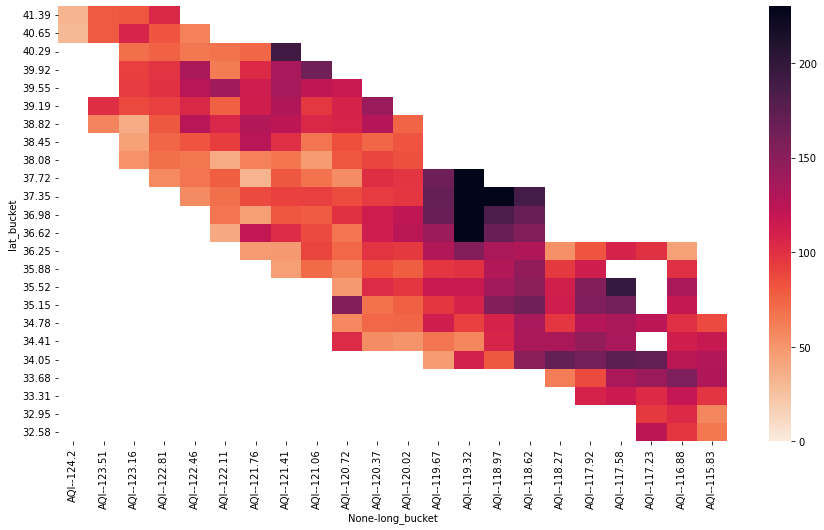

In [35]:
def fill_all(pivot_table):
    pv_copy = pivot_table.copy()

    for row in np.arange(len(pivot_table)):
        for col in np.arange(len(pivot_table.columns)):
            pv_copy.iloc[row, col] = fill_bucket(pivot_table, row, col)
    return pv_copy


filled_heatmap_data = fill_all(heatmap_data)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(filled_heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()   

In [36]:
grader.check("q8b")

q8b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 8c - Other Interpolation Ideas

Instead of just interpolating in a simple fashion as we did above, suggest one other way to interpolate (that actually works so do not just say "put the average of all cells in every `NaN` cell). For example, you can take into account of the distance of the surrounding cells, the number of cells you use, and more. 

<!--
BEGIN QUESTION
name: q8c
points: 2
manual: True
-->

To improve this interpolation, we can weight the values we find left, right, up, or down by their distance from the value we are imputing. In other words, we can follow our implementation from above while accounting for the distance from the missing value we are imputing. For example, if the “closest right cell” is 20 cells away, its value would be multiplied by 1/20 to account for the “weight” this value has on the missing value we are imputing. Likewise, if the “closest above cell” is 2 cells away, its value would be weighted more heavily (1/2 *value) in the average calculation of the 3 closest neighboring cells. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 9 - Choosing your Loss Function

Let us say that you are trying to define a loss function $L(x_{i}, y_{i})$ to use for model, where $x_{i}$ is the input and the $y_{i}$ is a qualitative variable that that model outputs, consisting of the following five groups: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. How would you design your loss function to evaluate your model?

<!--
BEGIN QUESTION
name: q9
manual: True
points: 2
-->

When deciding what loss function to use for our model, we considered mean cross-entropy loss and
mean squared error. We chose mean cross-entropy loss for the following reasons: 
- Cross-entropy is a better measure than MSE for classification because the decision boundary in a classification task is large (in comparison with regression) 
- MSE does not punish misclassifications enough (crossentropy loss more stronly penalizes bad predictions) 
- Loss surface is guaranteed to be convex for cross-entropy loss

In conclusion, mean cross-entropy loss is a suitable loss function for this classification problems
because it minimizes the distance between two probability distributions - predicted and actual.

<!-- END QUESTION -->



</br></br>

### Question 10: Creating your own Model!

Now that you have an idea of how to interpolate values, we will be using something more predictive. In this part, your final goal is to be creating a model and function that uses **at least four** features, with at least one of those four features being from an external dataset that you bring in and process yourself. Here are some rules on the model that you should follow: 

- Using your open-ended EDA analysis, use at least three features in the dataset provided to come up with some sort of predictive model for the AQI for remaining locations not predicted in the heatmap. You are **NOT** allowed to use any more than **one** of the particulate matter features for this model i.e. ozone or CO2 concentrations for example. 
    - The reason behind this is that AQI is directly based on these values, so there will be in some sense a near 100\% correlation between AQI and these features under some transformations. 
- Use at least one feature that comes from an external dataset of choice. Some examples are geographical region (categorical), elevation (quantitative), or wilfire data. 
    - Reference question 2c of this project to see how to merge external data with the current EPA data.
- Your model should, at the end, predict one of the following broad categories for the AQI: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. Note that this specification is different from `fill_bucket` in the sense that instead of returning a value, you will be returning a string for a category.
    - As a result, you can either directly predict the category, or the AQI (ex. through regression) and then convert to the category. Category ranges for AQI can be found online.
- The final model should be validated with some data that you hold out. You decide how to do this but there should be some model validation accuracy reported. You should be using the loss function that you designed in question 3 in order to do this.

---

#### Deliverables
<br/>

**`features`**: This should be a `pd.DataFrame` object that represents the design matrix that will be fed in as input to your model. Each row represents a data point and each column represents a feature. Essentially your $X$ matrix. 

**`targets`**: This should be a numpy array that where each value corresponds to the AQI value or AQI category for each of the data points in `features`. Essentially your $y$ vector. 

**`build_model`**: This function should have two parameters: `features` that will be used as input into your model as a `pd.DataFrame` object, and `targets` should be a numpy array of AQI values OR AQI categories. It should return a *function* or *object* that represents your model.

**`predict`**: This function should have two parameters: `model`, the model that you build from the previous function `build_model`, and `features` that represent the design matrix for the test values that we want to predict. It should return the **AQI category** (not a value) that the model predicts for these inputs.

<!-- BEGIN QUESTION -->

<br/>

### Question 10a: Choose Features and Model

First, decide on the features that you will be using for your model. How predictive do you think each of the features that you chose will be of the AQI category? Then, how will you choose to make your model (multiple regression, decision trees, etc.)?

<!--
BEGIN QUESTION
name: q10a
points: 2
manual: True
-->

The features we will be using for our model are Annual Average Daily Traffic (AADT), Annual Mean CO Concentration, Annual Mean Wind Direction, Annual Mean Wind Speed, Annual Mean Temperature, Max Temperature Hour, Month, Day. We hypothesize that the CO concentration will be very predictive of AQI because it is used in the calculation of AQI. AADT is directly related to CO levels in the atmosphere, so it will also be a good predictor of AQI. Month will also have a strong relationship with AQI because AQI fluctuates based on the time of year. We imagine that average temperature, max temperature hour, wind direction and speed, and day will also be indicative of AQI, but less so than the other features. We will use a random forest classifier to understand how strong the relationship is between our 8 independent variables (features) and our dependent variable, AQI.

<!-- END QUESTION -->

<br/>

### Question 10b: Build Features

Create the `build_features` function as described at the beginning of this part. You should also do any cleaning or merging of internal or external datasets in this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10b
points: 3
-->

In [37]:
#merge with CO table
daily_co = epa_data.get('daily_co')
daily_co_copy = daily_co.copy()
daily_co_copy = daily_co_copy[(daily_co_copy['State Code'] == 6)] #& (daily_co_copy['County Code'].isin([73, 1, 59, 67, 75, 37, 3, 5, 7, 9, 11, 13, 1, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115]))]
#daily_co_copy = daily_co_copy[daily_co_copy['Sample Duration'] == '8-HR RUN AVG END HOUR']

#add month and day columns
daily_co_copy['Month'] = daily_co_copy['Date Local'].str.split('-').str[1].astype('int')
daily_co_copy['Day'] = daily_co_copy['Date Local'].str.split('-').str[2].astype('int')

#rename gpd_epa_traffic columns to have Latitude and Longitude
gpd_epa_traffic.rename(columns = {'Site Lat' : "Latitude"}, inplace = True)
gpd_epa_traffic.rename(columns = {'Site Long': 'Longitude'}, inplace = True)

gpd_epa_traffic_co = pd.merge(gpd_epa_traffic, daily_co_copy, how='inner', on=['Latitude', 'Longitude', 'Month', 'Day']).drop_duplicates()

In [38]:
# select and rename columns for CO merge
gpd_epa_traffic_co = gpd_epa_traffic_co[['State Name_x', 'county Name', 'Month', 'Day', 'AQI_x','Category','Latitude', 'Longitude','AADT', 'Arithmetic Mean']]
gpd_epa_traffic_co.rename(columns = {'Arithmetic Mean' : "Annual Mean CO Concentration"}, inplace = True)
gpd_epa_traffic_co.rename(columns = {'AQI_x' : "AQI"}, inplace = True)
gpd_epa_traffic_co.rename(columns = {'State Name_x' : "State Name"}, inplace = True)

In [39]:
#merge with wind table for wind speed
daily_wind_speed = epa_data.get('daily_temp') #wind table in the temp folder
daily_wind_speed_copy = daily_wind_speed.copy()
daily_wind_speed_copy = daily_wind_speed_copy[(daily_wind_speed_copy['State Code'] == 6)] #& (daily_wind_speed_copy['County Code'].isin([73, 1, 59, 67, 75, 37, 3, 5, 7, 9, 11, 13, 1, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115]))]
daily_wind_speed_copy = daily_wind_speed_copy[daily_wind_speed_copy['Parameter Name'] == 'Wind Speed - Resultant'] 

#add month and day columns
daily_wind_speed_copy['Month'] = daily_wind_speed_copy['Date Local'].str.split('-').str[1].astype('int')
daily_wind_speed_copy['Day'] = daily_wind_speed_copy['Date Local'].str.split('-').str[2].astype('int')

gpd_epa_traffic_co_wind_speed = pd.merge(gpd_epa_traffic_co, daily_wind_speed_copy, how='inner', on=['Latitude', 'Longitude', 'Month', 'Day']).drop_duplicates()

In [40]:
# select and rename columns for wind speed merge
gpd_epa_traffic_co_wind_speed = gpd_epa_traffic_co_wind_speed[['State Name_x', 'county Name', 'Month', 'Day', 'AQI_x', 'Category','Latitude', 'Longitude', 'AADT', 'Annual Mean CO Concentration', 'Arithmetic Mean']]
gpd_epa_traffic_co_wind_speed.rename(columns = {'Arithmetic Mean' : "Annual Mean Wind Speed"}, inplace = True)
gpd_epa_traffic_co_wind_speed.rename(columns = {'AQI_x' : "AQI"}, inplace = True)
gpd_epa_traffic_co_wind_speed.rename(columns = {'State Name_x' : "State Name"}, inplace = True)

In [41]:
#merge with wind table again for wind direction
daily_wind_dir = epa_data.get('daily_temp') #wind table in the temp folder
daily_wind_dir_copy = daily_wind_dir.copy()
daily_wind_dir_copy = daily_wind_dir_copy[(daily_wind_dir_copy['State Code'] == 6)] #& (daily_wind_dir_copy['County Code'].isin([73, 1, 59, 67, 75, 37, 3, 5, 7, 9, 11, 13, 1, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115]))]
daily_wind_dir_copy = daily_wind_dir_copy[daily_wind_dir_copy['Parameter Name'] == 'Wind Direction - Resultant'] 

#add month and day columns
daily_wind_dir_copy['Month'] = daily_wind_dir_copy['Date Local'].str.split('-').str[1].astype('int')
daily_wind_dir_copy['Day'] = daily_wind_dir_copy['Date Local'].str.split('-').str[2].astype('int')

gpd_epa_traffic_co_wind_speed_dir = pd.merge(gpd_epa_traffic_co_wind_speed, daily_wind_dir_copy, how='inner', on=['Latitude', 'Longitude', 'Month', 'Day']).drop_duplicates()

In [42]:
# select and rename columns for wind direction merge
gpd_epa_traffic_co_wind_speed_dir = gpd_epa_traffic_co_wind_speed_dir[['State Name_x', 'county Name', 'Month', 'Day', 'AQI_x', 'Category','Latitude', 'Longitude', 'AADT', 'Annual Mean CO Concentration', 'Annual Mean Wind Speed', 'Arithmetic Mean']]
gpd_epa_traffic_co_wind_speed_dir.rename(columns = {'Arithmetic Mean' : "Annual Mean Wind Direction"}, inplace = True)
gpd_epa_traffic_co_wind_speed_dir.rename(columns = {'AQI_x' : "AQI"}, inplace = True)
gpd_epa_traffic_co_wind_speed_dir.rename(columns = {'State Name_x' : "State Name"}, inplace = True)
gpd_epa_traffic_co_wind_speed_dir.rename(columns = {'Category' : "AQI Category"}, inplace = True)

In [43]:
#merge with temperature table
daily_temp = epa_data.get('daily_wind') #temp table in the wind folder
daily_temp_copy = daily_temp.copy()
daily_temp_copy = daily_temp_copy[(daily_temp_copy['State Code'] == 6)] #& (daily_wind_dir_copy['County Code'].isin([73, 1, 59, 67, 75, 37, 3, 5, 7, 9, 11, 13, 1, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115]))]

#add month and day columns
daily_temp_copy['Month'] = daily_temp_copy['Date Local'].str.split('-').str[1].astype('int')
daily_temp_copy['Day'] = daily_temp_copy['Date Local'].str.split('-').str[2].astype('int')

gpd_epa_traffic_co_wind_speed_dir_temp_mean = pd.merge(gpd_epa_traffic_co_wind_speed_dir, daily_temp_copy, how='inner', on=['Latitude', 'Longitude', 'Month', 'Day']).drop_duplicates()

In [44]:
# select and rename columns for temperature merge
gpd_epa_traffic_co_wind_speed_dir_temp_mean = gpd_epa_traffic_co_wind_speed_dir_temp_mean[['State Name_x', 'county Name', 'Month', 'Day', 'AQI_x', 'AQI Category','Latitude', 'Longitude', 'AADT', 'Annual Mean CO Concentration', 'Annual Mean Wind Speed', 'Annual Mean Wind Direction', 'Arithmetic Mean']]
gpd_epa_traffic_co_wind_speed_dir_temp_mean.rename(columns = {'Arithmetic Mean' : "Annual Mean Temperature"}, inplace = True)
gpd_epa_traffic_co_wind_speed_dir_temp_mean.rename(columns = {'AQI_x' : "AQI"}, inplace = True)
gpd_epa_traffic_co_wind_speed_dir_temp_mean.rename(columns = {'State Name_x' : "State Name"}, inplace = True)

In [45]:
#merge with temperature table for 1st max hour
daily_temp = epa_data.get('daily_wind') #temp table in the wind folder
daily_temp_copy = daily_temp.copy()
daily_temp_copy = daily_temp_copy[(daily_temp_copy['State Code'] == 6)] #& (daily_wind_dir_copy['County Code'].isin([73, 1, 59, 67, 75, 37, 3, 5, 7, 9, 11, 13, 1, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115]))]

#add month and day columns
daily_temp_copy['Month'] = daily_temp_copy['Date Local'].str.split('-').str[1].astype('int')
daily_temp_copy['Day'] = daily_temp_copy['Date Local'].str.split('-').str[2].astype('int')

gpd_epa_traffic_co_wind_speed_dir_temp_mean_hour = pd.merge(gpd_epa_traffic_co_wind_speed_dir_temp_mean, daily_temp_copy, how='inner', on=['Latitude', 'Longitude', 'Month', 'Day']).drop_duplicates()

In [46]:
# select and rename columns for temperature 1st hour max merge
gpd_epa_traffic_co_wind_speed_dir_temp_mean_hour = gpd_epa_traffic_co_wind_speed_dir_temp_mean_hour[['State Name_x', 'county Name', 'Month', 'Day', 'AQI_x', 'AQI Category','Latitude', 'Longitude', 'AADT', 'Annual Mean CO Concentration', 'Annual Mean Wind Speed', 'Annual Mean Wind Direction', 'Annual Mean Temperature', '1st Max Hour']]
gpd_epa_traffic_co_wind_speed_dir_temp_mean_hour.rename(columns = {'1st Max Hour' : "Max Temperature Hour"}, inplace = True)
gpd_epa_traffic_co_wind_speed_dir_temp_mean_hour.rename(columns = {'AQI_x' : "AQI"}, inplace = True)
gpd_epa_traffic_co_wind_speed_dir_temp_mean_hour.rename(columns = {'State Name_x' : "State Name"}, inplace = True)

In [47]:
#features: This should be a pd.DataFrame object that represents the design 
#matrix that will be fed in as input to your model. Each row represents a data 
#point and each column represents a feature. Essentially your  𝑋  matrix.

features = gpd_epa_traffic_co_wind_speed_dir_temp_mean_hour[['AADT', 'Annual Mean CO Concentration', 'Annual Mean Wind Direction', 'Annual Mean Wind Speed', 'Annual Mean Temperature', 'Max Temperature Hour', 'Month', 'Day']]

#targets: This should be a numpy array that where each value corresponds to the 
#AQI value or AQI category for each of the data points in features. Essentially 
#your  𝑦  vector.

targets = gpd_epa_traffic_co_wind_speed_dir_temp_mean_hour['AQI Category'].str.lower()

features.head() 

,AADT,Annual Mean CO Concentration,Annual Mean Wind Direction,Annual Mean Wind Speed,Annual Mean Temperature,Max Temperature Hour,Month,Day
0,112900,0.492217,158.083333,1.329167,47.100000,13,1,3
1,112900,0.487500,158.083333,1.329167,47.100000,13,1,3
2,112900,0.380000,193.416667,1.158333,46.341667,14,1,5
3,112900,0.383333,193.416667,1.158333,46.341667,14,1,5
4,112900,0.332826,212.791667,1.612500,43.329167,14,1,6


In [48]:
grader.check("q10b")

q10b results: All test cases passed!

<br/>

### Question 10c: Build Your Model!

Create the `build_model` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10c
points: 8
-->

In [49]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

def build_model(features, targets):
    '''This function should have two parameters: features that will be 
    used as input into your model as a pd.DataFrame object, and targets 
    should be a numpy array of AQI values OR AQI categories. It should 
    return a function or object that represents your model.'''
    model = RandomForestClassifier()
    model.fit(features, targets)
    return model

build_model(features, targets)

RandomForestClassifier()

In [50]:
grader.check("q10c")

q10c results: All test cases passed!

<br/>

### Question 10d: Predict Points

Create the `predict` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10d
points: 4
-->

In [51]:
categories = ["good", "moderate", "unhealthy for sensitive groups", "unhealthy", "very unhealthy", "hazardous"]

def predict(model, features):
    '''This function should have two parameters: model, the model 
    that you build from the previous function build_model, and features 
    that represent the design matrix for the test values that we want to 
    predict. It should return the AQI category (not a value) that the 
    model predicts for these inputs.'''
    aqi = model.predict(features)
    return aqi

In [52]:
grader.check("q10d")

q10d results: All test cases passed!

<br/>

### Question 10e: Model Validation and Performance

Now that you have finished making your model, we want to see how well it performs on our data. In this question, use the following cell to split your data into training and validation sets. You should partition 70\% of your data to be used as your training set, and the remaining to be used as your validation set. 

Assign `binary_error` to be the **fraction of inputs on your validation set that the your `predict` function classifies incorrectly.** Note that this is a binary loss in some sense as it assigns a loss of 1 to those points predicted incorrectly, and a loss of 0 to those points predicted correctly.

Assign `cv_error` to be the the error on the validation set produced by the loss function $ L $ that you designed in question 3.

*Hint*: you can use `train_test_split` from `sklearn`.

<!--
BEGIN QUESTION
name: q10e
points: 8
-->

In [53]:
categories = ["good", "moderate", "unhealthy for sensitive groups", "unhealthy", "very unhealthy", "hazardous"]
import sklearn.model_selection
   
num_targets = targets.apply(lambda x: categories.index(x))            
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, num_targets, test_size=0.3, train_size=0.7)

model = build_model(X_train, y_train)
result = predict(model, X_test)
bool_array = result == y_test
accuracy = np.sum(bool_array) / len(result)
print('Accuracy: ', accuracy)

binary_error = 1 - accuracy
print('Binary Error: ', binary_error)

# compute Cross Entropy Loss
prob_results = model.predict_proba(X_test)
cv_error =  -1 * np.mean(np.apply_along_axis(np.log, 0, np.apply_along_axis(max, 1, prob_results)))
print('CV Error: ', cv_error)

Accuracy:  0.9262820512820513
Binary Error:  0.07371794871794868
CV Error:  0.28177323737251814


In [54]:
grader.check("q10e")

q10e results: All test cases passed!

<br/><br/>

---
## Part 5: Open-Ended Modeling

Now that you have had some experience with creating the a model from scratch using the existing data, you are now ready to explore other questions, such as the ones in your design document. In this section, you will use the tools that we developed in the previous parts to answer the hypothesis of your choice! Note that breaking your model-building and analysis process into modularized functions as you did above will make your code more interpretable and less error-prone. 

<!-- BEGIN QUESTION -->

### Question 11a

Train a baseline model of your choice using any supervised learning approach we have studied to answer your hypothesis and predict something related to AQI; you are not limited to a linear model. However, you may use a maximum of **three features** for this part. After training, evaluate it on some validation data that you hold out yourself. 

<!--
BEGIN QUESTION
name: q11a
points: 5
manual: True
-->

In [55]:
def categorize_aqi(value):
    if value > 300:
        return "hazardous"
    if value > 200:
        return "very unhealthy"
    if value > 150:
        return "unhealthy"
    if value > 100:
        return "unhealthy for sensitive groups"
    if value > 50:
        return "moderate"
    return "good"

In [56]:
# load and clean the income dataset
income = pd.read_csv('data/IncomeData.csv')
income = income.rename(columns = {'Table 1. Per Capita Personal Income, by County, 2018–2020': 'County Name',
                                 'Unnamed: 3': 'Income 2020 ($)', 
                                 'Unnamed: 4': 'Income Rank in State'})
income = income[['County Name', 'Income 2020 ($)', 'Income Rank in State']]
income = income[202:260]

In [57]:
# merge income with ozone

daily_ozone = epa_data.get('daily_ozone')
daily_ozone_copy = daily_ozone.copy()
daily_ozone_copy = daily_ozone_copy[daily_ozone_copy['State Code'] == 6]

income_ozone = pd.merge(income, daily_ozone_copy, how='inner', on=['County Name']).drop_duplicates()
income_ozone = income_ozone[['County Name', 'Income 2020 ($)', 'Income Rank in State', 'Arithmetic Mean', 'AQI', 'Date Local']]
income_ozone = income_ozone.rename(columns = {'Arithmetic Mean': 'Mean Ozone Concentration'})
income_ozone['Income 2020 ($)'] = income_ozone['Income 2020 ($)'].str.replace(',', '').astype('int')
income_ozone['AQI Category'] = income_ozone['AQI'].apply(categorize_aqi)
income_ozone.head()

,County Name,Income 2020 ($),Income Rank in State,Mean Ozone Concentration,AQI,Date Local,AQI Category
0,Alameda,87078,6,0.019471,23,2020-01-01,good
1,Alameda,87078,6,0.007882,16,2020-01-02,good
2,Alameda,87078,6,0.005706,12,2020-01-03,good
3,Alameda,87078,6,0.012647,26,2020-01-04,good
4,Alameda,87078,6,0.015059,29,2020-01-05,good


In [58]:
#features: This should be a pd.DataFrame object that represents the design 
#matrix that will be fed in as input to your model. Each row represents a data 
#point and each column represents a feature. Essentially your  𝑋  matrix.

features_11 = income_ozone[['Income 2020 ($)', 'Income Rank in State', 'Mean Ozone Concentration']]

#targets: This should be a numpy array that where each value corresponds to the 
#AQI value or AQI category for each of the data points in features. Essentially 
#your  𝑦  vector.

targets_11 = income_ozone['AQI']
targets_cat_11 = income_ozone['AQI Category']

In [59]:
from sklearn.linear_model import LogisticRegression

def build_model_11(features, targets):
    '''This function should have two parameters: features that will be 
    used as input into your model as a pd.DataFrame object, and targets 
    should be a numpy array of AQI values OR AQI categories. It should 
    return a function or object that represents your model.'''
    model = LogisticRegression(fit_intercept = True, multi_class='multinomial', solver='lbfgs')
    model.fit(features, targets)
    return model
build_model_11(features_11, targets_cat_11)

LogisticRegression(multi_class='multinomial')

In [60]:
def predict_11(model, features):
    '''This function should have two parameters: model, the model 
    that you build from the previous function build_model, and features 
    that represent the design matrix for the test values that we want to 
    predict. It should return the AQI category (not a value) that the 
    model predicts for these inputs.'''
    return model.predict(features)

In [61]:
import sklearn.model_selection
X_train_11, X_test_11, y_train_11, y_test_11 = sklearn.model_selection.train_test_split(features_11, targets_cat_11, test_size=0.3, train_size=0.7)

model = build_model_11(X_train_11, y_train_11)
result = predict_11(model, X_test_11)
bool_array = result == y_test_11
accuracy = np.sum(bool_array) / len(result)

binary_error = 1 - accuracy
print('Binary Error: ', binary_error)

# compute Cross Entropy Loss
prob_results = model.predict_proba(X_test_11)
cv_error =  -1 * np.mean(np.apply_along_axis(np.log, 0, np.apply_along_axis(max, 1, prob_results)))
print('CV Error: ', cv_error)

Binary Error:  0.19727327924049232
CV Error:  0.22584475263376538


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11b

Explain and summarize the model that you used. In your summary, make sure to include the model description, the inputs, the outputs, as well as the cross-validation error. Additionally, talk a little bit about what you would change to your baseline model to improve it. The expected length of your summary should be 8-12 sentences. 

<!--
BEGIN QUESTION
name: q11b
points: 2
manual: True
-->

We decided to develop a new research topic based on the creativity feedback we received in Part 1, and subsequently we developed a new hypothesis for this part of our modeling. For our open ended modeling, we are investigating the relationship between the Air Quality Index and wealth across different counties in California. We chose this topic because we believe it is important to understand how the health implications associated with high Air Quality Index may disproportionately affect populations based on socioeconomic status. Our research question is: what is the relationship between Air Quality Index and wealth across different counties in California? Our hypothesis is that California counties with lower average income will have worse Air Quality Index, because lower-income communities are historically host to a higher number of factories and power plants that emit harmful pollutants into the atmosphere. We will be able to confirm our hypothesis by observing our final model's accuracy, binary error, and cross validation error. 

To investigate this topic, we constructed a multinomial logistic model that can predict Air Quality Index category. We chose this model because logistic regression is preferable for the prediction of categorical variables (such as Air Quality Index category). We believe that income and Air Quality Index are negataively correlated and so the features we used to assemble this model include county income, county income rank within California, and mean ozone concentration in the year 2020. We chose the first two features because they are indicative of average socioeconimic status of various counties across California, and the last feature because we have previously seen a relationship between ozone and Air Quality Index in Part 1 of the project. To observe these features, we consulted an income external dataset. After loading in the data, we performed cleaning on the dataframe in which we filtered by state, and then merged with our pre-existing dataframes by County Name. 

    
Our model had an accuracy of about 80%, a binary error of about 20%, and a cross validation error of about 23%. Our accuracy of about 80% indicates that our model is not very good because it is not better than 83% (1 - 1/6) which is the expected accuracy of a random baseline guesser with 6 classes. We would like to improve our accuracy by making some changes to our model in 11c to more accurately reflect our topic, including the modification of our features and the type of model used. 

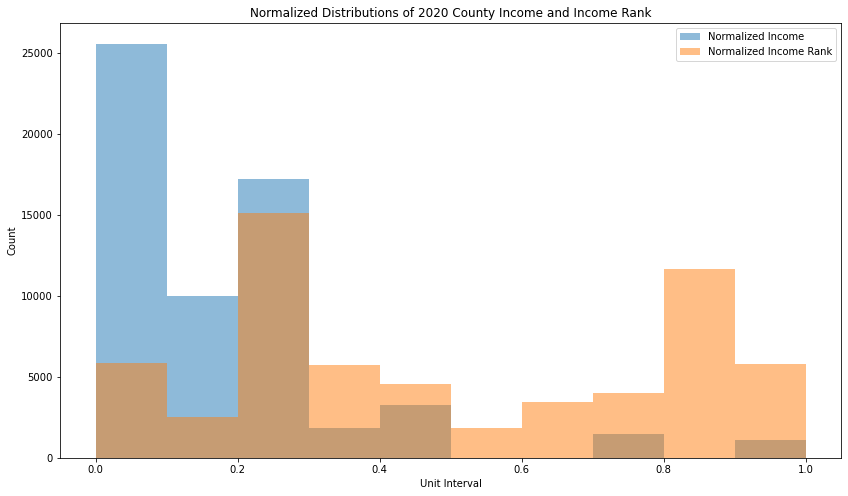

In [62]:
# Visualization 1

normalized_income = (income_ozone['Income 2020 ($)']-min(income_ozone['Income 2020 ($)']))/(max(income_ozone['Income 2020 ($)'])-min(income_ozone['Income 2020 ($)']))
rank_as_int = income_ozone['Income Rank in State'].astype('int') #first convert to int
normalized_income_rank = (rank_as_int-min(rank_as_int))/(max(rank_as_int)-min(rank_as_int))

plt.figure(figsize=(14, 8))
plt.hist(normalized_income, alpha=0.5, label="Normalized Income")
plt.hist(normalized_income_rank, alpha=0.5, label="Normalized Income Rank")
plt.title('Normalized Distributions of 2020 County Income and Income Rank')
plt.xlabel('Unit Interval')
plt.ylabel('Count')
plt.legend();

**Plot 1 Takeaway:** Upon observing the distributions of normalized income and normalized income rank of 2020 California counties, we observe that the two distributions are similar because they are indicative of the same trend of county wealth. Given this, including both variables as features in our model will not improve its ability to predict AQI. Therefore, we will consider removing one of these variables from our features in question 11c. 

In [63]:
# load and clean the unemployment table
unemployment = pd.read_csv('data/Unemployment.csv')
unemployment = unemployment.iloc[199:257, [2,-4]]
unemployment = unemployment.rename(columns = {'Unnamed: 2': 'County Name', 'Unnamed: 88':'2020 Unemployment Count'})
unemployment['County Name'] = unemployment['County Name'].str[:-11]
unemployment['2020 Unemployment Count'] = unemployment['2020 Unemployment Count'].str.replace(',', '').astype('int')

unemployment.head()

,County Name,2020 Unemployment Count
199,Alameda,71396
200,Alpine,58
201,Amador,1317
202,Butte,8509
203,Calaveras,1619


In [64]:
# merge unemployment with income_ozone
income_ozone_unemployment = pd.merge(income_ozone, unemployment, how='inner', on=['County Name']).drop_duplicates()
income_ozone_unemployment.head()

,County Name,Income 2020 ($),Income Rank in State,Mean Ozone Concentration,AQI,Date Local,AQI Category,2020 Unemployment Count
0,Alameda,87078,6,0.019471,23,2020-01-01,good,71396
1,Alameda,87078,6,0.007882,16,2020-01-02,good,71396
2,Alameda,87078,6,0.005706,12,2020-01-03,good,71396
3,Alameda,87078,6,0.012647,26,2020-01-04,good,71396
4,Alameda,87078,6,0.015059,29,2020-01-05,good,71396


<Figure size 1008x576 with 0 Axes>

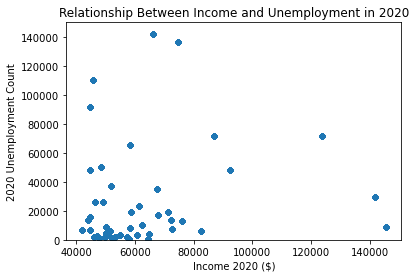

In [65]:
# Visualization 2

plt.figure(figsize=(14, 8));
income_ozone_unemployment.plot.scatter(x = 'Income 2020 ($)', y = '2020 Unemployment Count');

plt.ylim([0, 150000]);
plt.title('Relationship Between Income and Unemployment in 2020');
plt.xlabel('Income 2020 ($)');
plt.ylabel('2020 Unemployment Count');

**Plot 2 Takeaway:** This scatter plot shows there is a correlation between unemployment and income. Since income is a key feature in our model, and unemployment has an association with it, this scatter plot guided us to bring unemployment in as another feature to improve our model.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11c

Improve your model from part 11a based on the improvements that you suggested in part 11b. This could be the addition of more features, performing additional transformations on your features, increasing/decreasing the complexity of the model itself, or really anything else. You have no limitation on the number of features you can use, but you are required to use at least **one external dataset** that you process and merge in yourself. 

<!--
BEGIN QUESTION
name: q11c
points: 8
manual: True
-->

In [67]:
#features: This should be a pd.DataFrame object that represents the design 
#matrix that will be fed in as input to your model. Each row represents a data 
#point and each column represents a feature. Essentially your  𝑋  matrix.

features_11c = income_ozone_unemployment[['Income 2020 ($)', '2020 Unemployment Count', 'Mean Ozone Concentration']]

#targets: This should be a numpy array that where each value corresponds to the 
#AQI value or AQI category for each of the data points in features. Essentially 
#your  𝑦  vector.

targets_11c = income_ozone_unemployment['AQI']
targets_cat_11c = income_ozone_unemployment['AQI Category']

In [68]:
from sklearn.ensemble import RandomForestClassifier

def build_model_11c(features, targets):
    '''This function should have two parameters: features that will be 
    used as input into your model as a pd.DataFrame object, and targets 
    should be a numpy array of AQI values OR AQI categories. It should 
    return a function or object that represents your model.'''
    model = RandomForestClassifier()
    model.fit(features, targets)
    return model
build_model_11c(features_11c, targets_cat_11c)

RandomForestClassifier()

In [69]:
def predict_11c(model, features):
    '''This function should have two parameters: model, the model 
    that you build from the previous function build_model, and features 
    that represent the design matrix for the test values that we want to 
    predict. It should return the AQI category (not a value) that the 
    model predicts for these inputs.'''
    return model.predict(features)

predict_11c(build_model_11c(features_11c, targets_cat_11c), features_11c)

array(['good', 'good', 'good', ..., 'good', 'good', 'good'], dtype=object)

In [70]:
# Note: Your binary_error in question 10e should be < 0.3. The local autograder 
# has a mistake that it says that it should be < 30. I will update the autograder 
# shortly but make sure that it is less than this value. 

import sklearn.model_selection
X_train_11c, X_test_11c, y_train_11c, y_test_11c = sklearn.model_selection.train_test_split(features_11c, targets_cat_11c, test_size=0.3, train_size=0.7)

# should use validation set
model_11c = build_model_11c(X_train_11c, y_train_11c)
result_11c = predict_11c(model_11c, X_test_11c)
bool_array = result_11c == y_test_11c
accuracy_11c = np.sum(bool_array) / len(result_11c) #correctly predicted / total_rows

binary_error_11c = 1 - accuracy_11c # 1 - accuracy
print('Binary Error: ', binary_error_11c)

# compute Cross Entropy Loss
prob_results_11c = model.predict_proba(X_test_11c)
cv_error_11c =  -1 * np.mean(np.apply_along_axis(np.log, 0, np.apply_along_axis(max, 1, prob_results_11c)))
print('CV Error: ', cv_error_11c)

Binary Error:  0.14242019797575356
CV Error:  0.00904120197651171


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11d

Compare and contrast your baseline model and (hopefully) improved model. Make sure to compare their validation errors. Were you able to successfully answer your research question and evaluate your hypothesis? Summarize in a few sentences the conclusions that you can draw from your model and predictions. The expected length of your response should be 8-10 sentences. 

<!--
BEGIN QUESTION
name: q11d
points: 3
manual: True
-->

In our baseline model, we used a logistic regression initially since we were trying to predict categorical values and see the relationship between income and AQI categories. The features we selected were income for the year 2020 in each county in California which is a continuous variable, ranking of counties by income which is discrete, and mean ozone concentration which is also continuous. We chose the income feature from an external dataset as it was most relevant to our hypothesis, while we decided on Ozone concentration based on a research paper where a relationship was suggested between Ozone and income. Training a binary classifier gave us an accuracy of around 80%, while the cross-validation error was about 22%. Our accuracy of about 80% means that the model can be improved because it is below 83% (1 - 1/6) which is the expected accuracy of a random baseline guesser with 6 classes. We used a cross-entropy loss function for the cross-validation error, which minimizes the distance between predicted and actual probability distributions.

The first improvement we made was to change the model we used. Instead of logistic regression, we opted to use a Random Forest model. Random Forest Classifier performs better with more categorical data than numeric and logistic regression. Random selection in individual decision trees of random forest classification can capture more complex feature patterns to provide better accuracy. This improved the accuracy and reduced both binary classification error and cross-validation error. This improved the accuracy and reduced both binary classification error and cross-validation error.

The second improvement we made is we dropped the feature which ranked counties by income since it was proportionally similar to what income was providing as seen in the histogram comparing normalized income and normalized income rank. In its place, we brought in an external dataset of the number of unemployed people. The number of unemployed people in a county is correlated with its income level as seen in the scatter plot and hence, was an interesting feature to include to improve our model.

These two improvements increased our accuracy from around 80% to 85%. It reduced binary classification error from about 19% to 14% and cross-validation error from approximately 22% to around 1%, which is a significant improvement. 

The goal was to see whether low-income counties have worse AQIs compared to high-income counties. We were able to answer our research question successfully. It confirmed our hypothesis that California counties with lower personal income will have worse AQIS than counties with higher personal incomes, as demonstrated by our high model accuracy. This tells us that, indeed low-income communities are at a higher risk of facing the adverse effects of bad air quality since they are more likely to live in areas with worse AQI. There are various reasons why low-income communities are subject to bad AQI. One reason we have come across is that factories and power plants which emit much of the gasses that contribute to bad AQI are often located in low-income neighborhoods. The location of such factories and power plants results in low prices of housing. The other reasons behind low-income communities having bad AQI can be explored further.

**Future Work**

Before anything else, the reasons behind low-income communities having bad AQI should be explored further. This is related to the work we did in the sense that it will allow us to understand the reasoning behind the association of AQI and income. This will inform us of trends and patterns in the reasons behind the relationship between worsening AQI and low income. A flaw in the work we did was that it does not reveal whether certain communities are unfairly subject to bad AQI. As such, it can also be researched whether the explored reasons disproportionally affect certain communities more than others. This would allow us to see which communities within low-income areas are more affected by bad AQI and the reasons behind them. This can potentially allow us to predict better not only which communities are disproportionately impacted by bad air quality but also take measures to improve them.